In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/demand.csv')
df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [3]:
df.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [4]:
median = df.groupby('sku_id')['total_price'].median()

df['total_price'] = df['total_price'].fillna(df['sku_id'].map(median))

In [5]:
df.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [6]:
df['week'] = pd.to_datetime(df['week'], format='%d/%m/%y')

weekly_data = df.groupby('week')['units_sold'].sum().reset_index()

weekly_data.head()

,week,units_sold
0,2011-01-17,60029
1,2011-01-24,56752
2,2011-01-31,51467
3,2011-02-07,54656
4,2011-02-14,109207


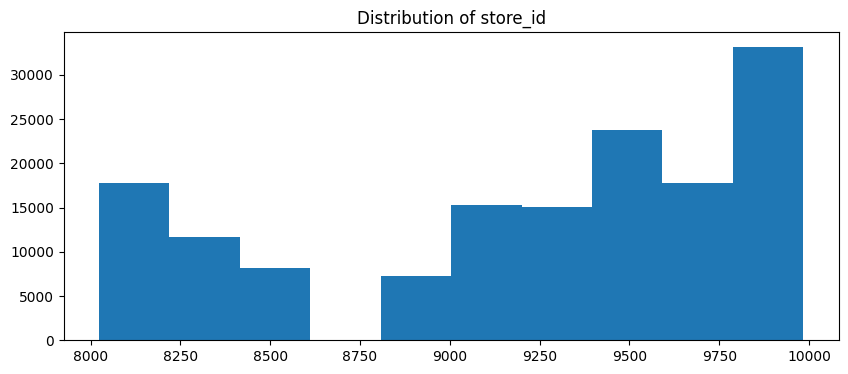

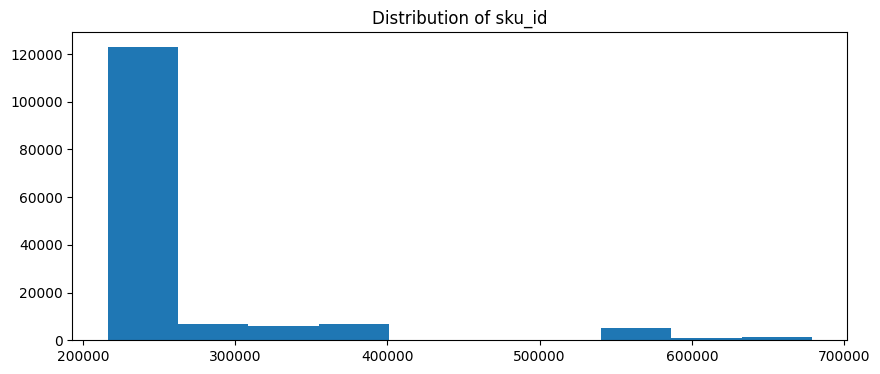

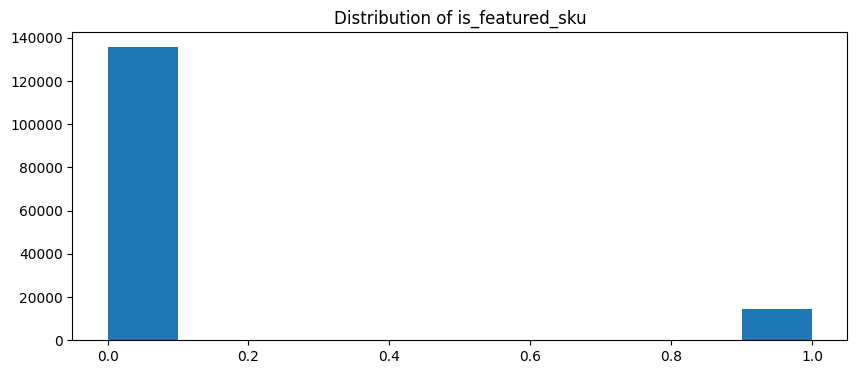

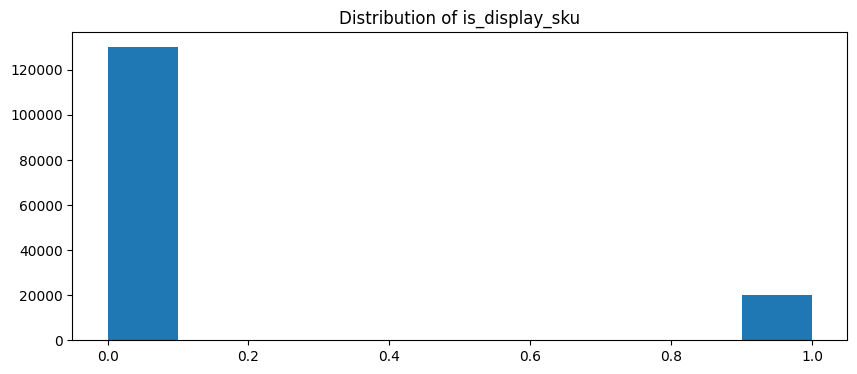

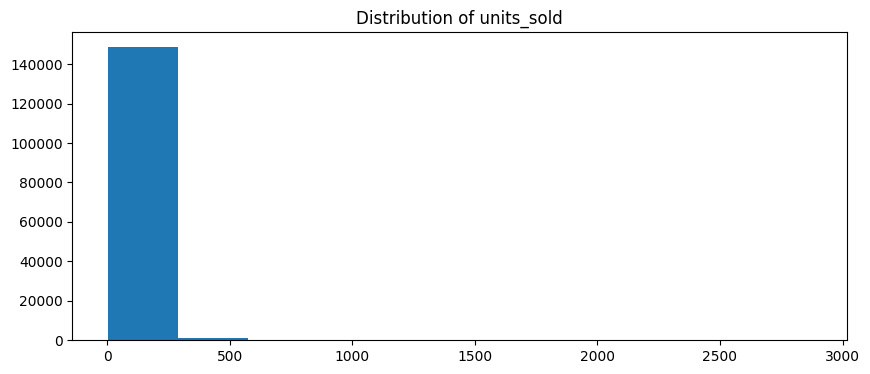

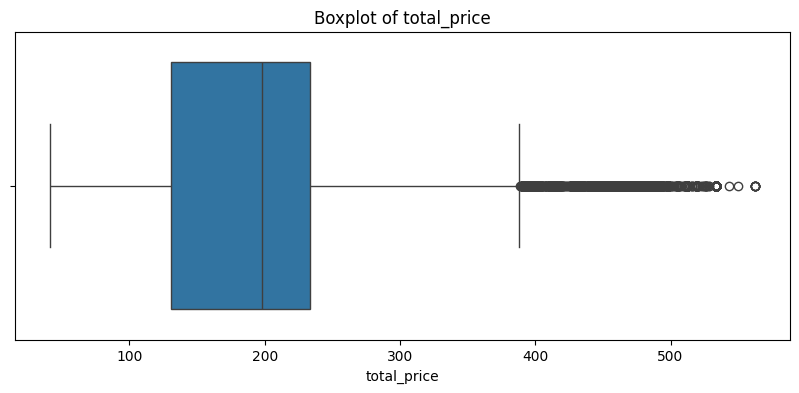

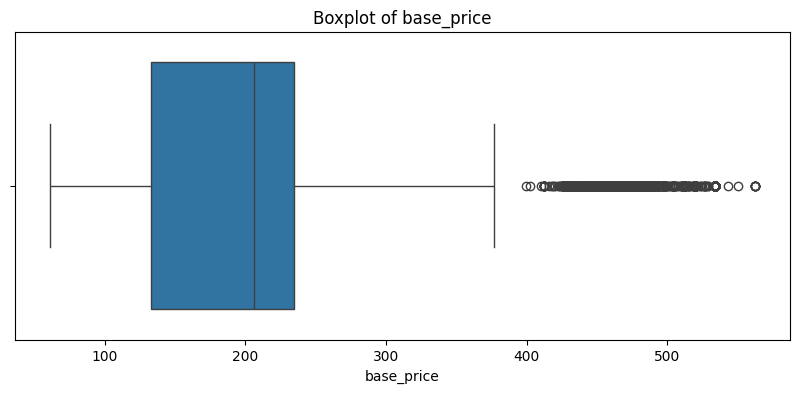

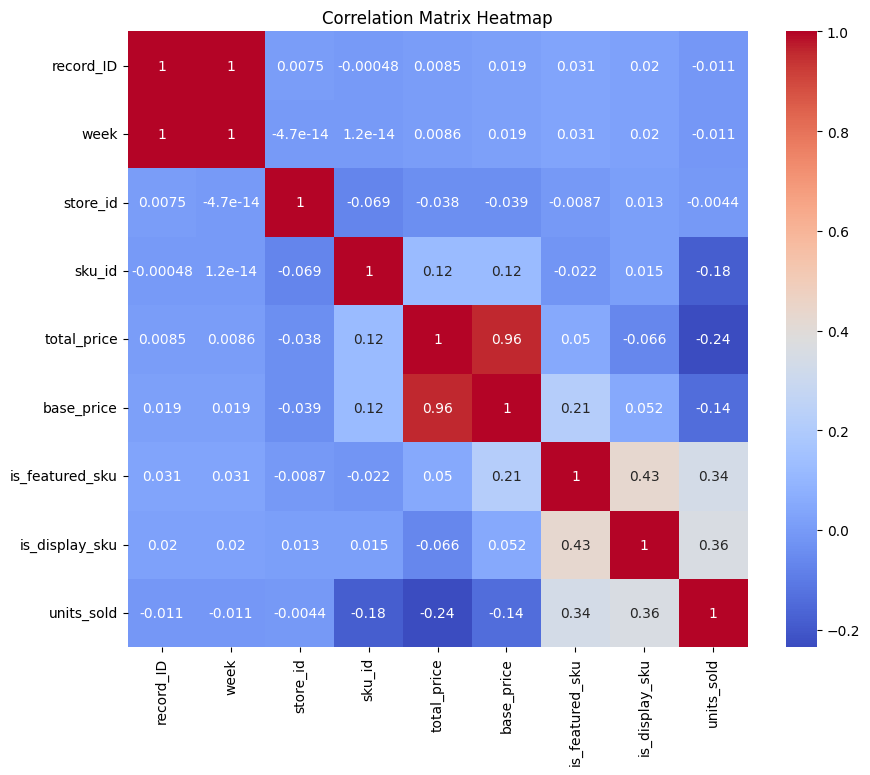

In [7]:
categorical_col = ['store_id',
 'sku_id',
 'is_featured_sku',
 'is_display_sku',
 'units_sold']

for col in categorical_col:
    plt.figure(figsize=(10,4))
    plt.hist(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()
    
numerical_col = ['total_price', 'base_price']

for col in numerical_col:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
    

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

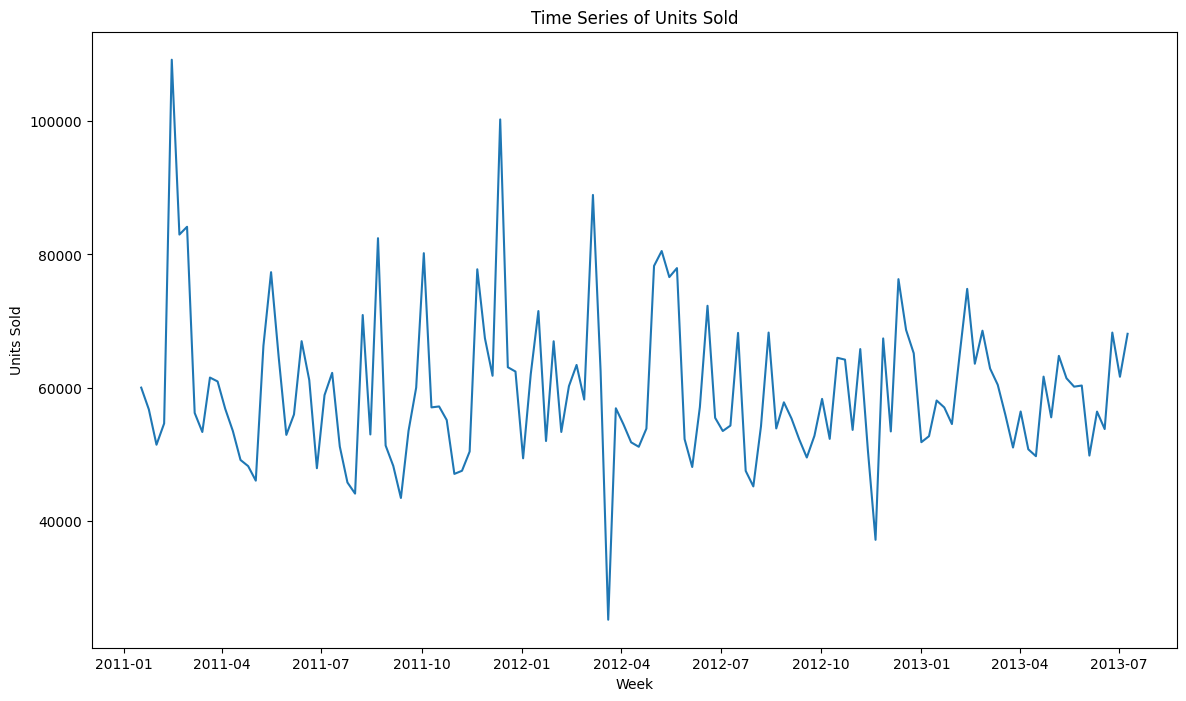

In [8]:
plt.figure(figsize=(14,8))
plt.plot(weekly_data['week'], weekly_data['units_sold'])
plt.title('Time Series of Units Sold')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.show()

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_data.set_index('week', inplace=True)
decomposition = seasonal_decompose(weekly_data['units_sold'], period=52)

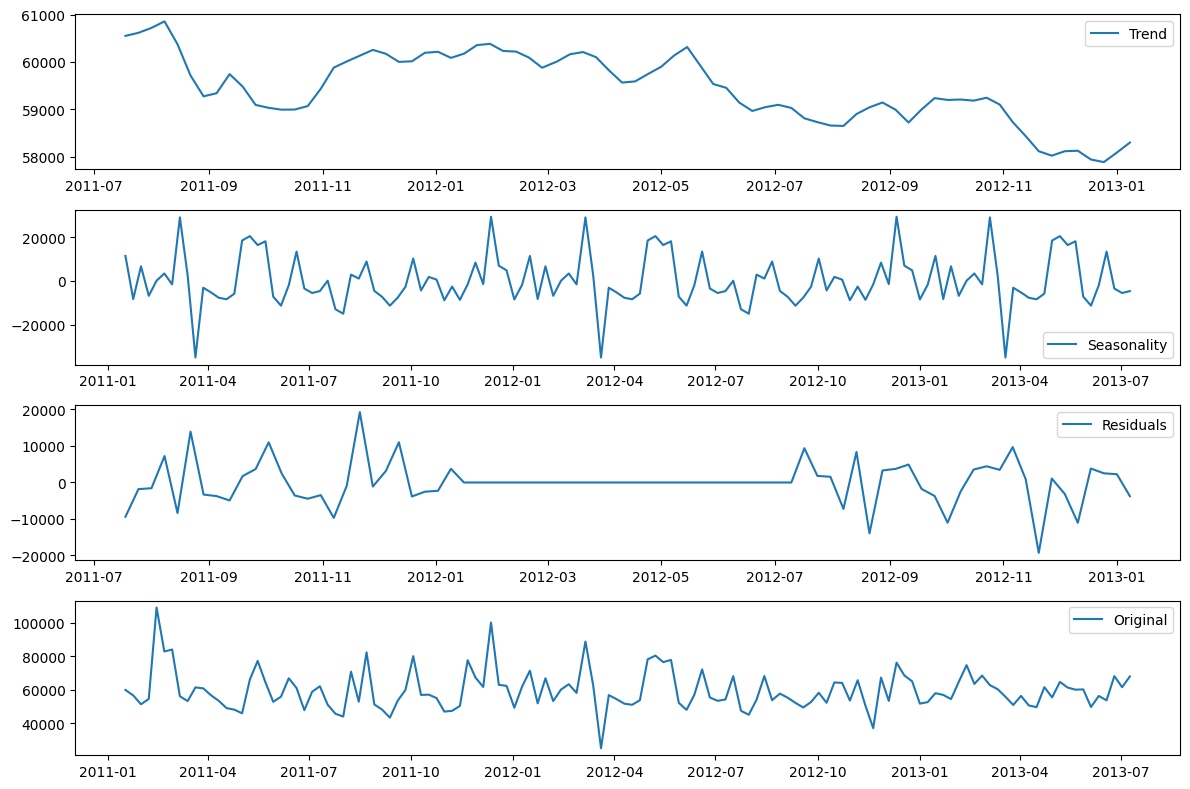

In [10]:
plt.figure(figsize=(12,8))

# Trend
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

# Seasonality
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')

# Residuals
plt.subplot(413)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')

# Original
plt.subplot(414)
plt.plot(weekly_data['units_sold'], label='Original')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

#### volatility

In [11]:
weekly_data['units_sold_pct_change'] = weekly_data['units_sold'].pct_change()
weekly_data.head()

,units_sold,units_sold_pct_change
week,,
2011-01-17,60029,NaN
2011-01-24,56752,-0.054590
2011-01-31,51467,-0.093124
2011-02-07,54656,0.061962
2011-02-14,109207,0.998079


In [12]:
volatility = weekly_data['units_sold_pct_change'].std()
volatility

np.float64(0.26059855014523764)

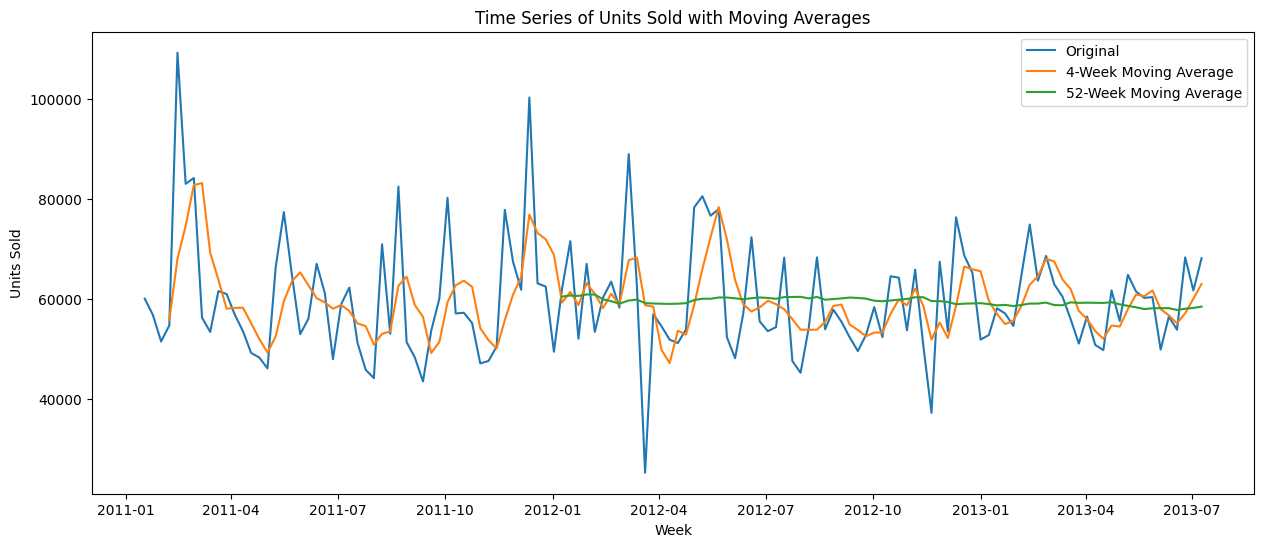

In [13]:
weekly_data['4_week_MA'] = weekly_data['units_sold'].rolling(window=4).mean()
weekly_data['52_week_MA'] = weekly_data['units_sold'].rolling(window=52).mean()

plt.figure(figsize=(15, 6))

plt.plot(weekly_data['units_sold'], label='Original')
plt.plot(weekly_data['4_week_MA'], label='4-Week Moving Average')
plt.plot(weekly_data['52_week_MA'], label='52-Week Moving Average')

plt.title('Time Series of Units Sold with Moving Averages')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.legend()

plt.show()

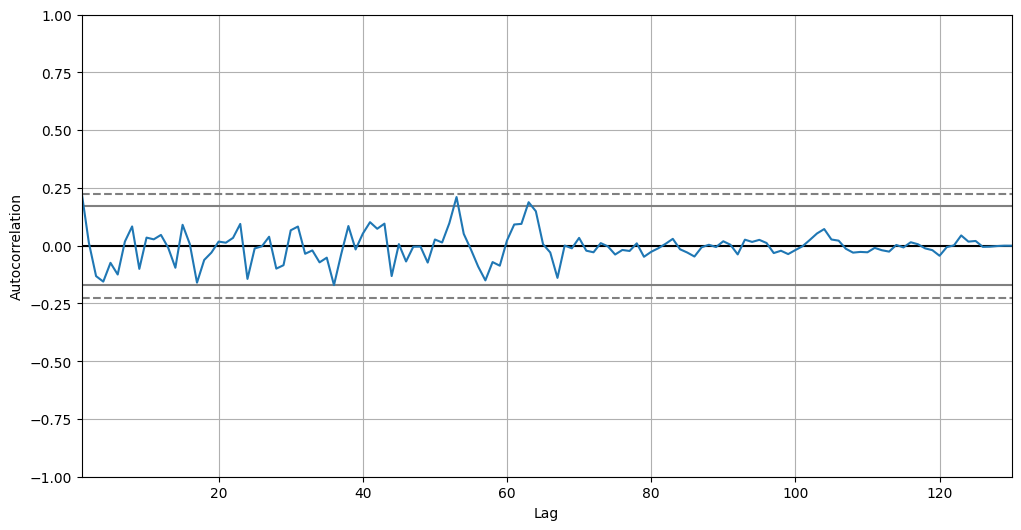

In [14]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12,6))
autocorrelation_plot(weekly_data['units_sold'])
plt.show()

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Split the data into train and test sets
train_data = weekly_data['units_sold'][:int(0.8*(len(weekly_data)))]
test_data = weekly_data['units_sold'][int(0.8*(len(weekly_data)))]

# Fit Model
model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=52).fit()

C:\Users\User\AppData\Local\Temp\ipykernel_15296\4149404251.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data = weekly_data['units_sold'][int(0.8*(len(weekly_data)))]
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [16]:
weekly_data['units_sold'].head()

week
2011-01-17     60029
2011-01-24     56752
2011-01-31     51467
2011-02-07     54656
2011-02-14    109207
Name: units_sold, dtype: int64

In [17]:
weekly_data_resample = weekly_data['units_sold'].resample('W').sum()
weekly_data_resample.head()

week
2011-01-23     60029
2011-01-30     56752
2011-02-06     51467
2011-02-13     54656
2011-02-20    109207
Freq: W-SUN, Name: units_sold, dtype: int64

In [18]:
train_data_resample = weekly_data_resample[:int(0.8*(len(weekly_data_resample)))]
test_data_resample = weekly_data_resample[int(0.8*(len(weekly_data_resample))):]

# Fit Model
model_resample = ExponentialSmoothing(train_data_resample, seasonal='add', seasonal_periods=52).fit()

predictions_resample = model_resample.predict(start=test_data_resample.index[0], end=test_data_resample.index[-1])

rmse_resample = np.sqrt(mean_squared_error(test_data_resample, predictions_resample))
rmse_resample

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


np.float64(13387.603026274608)

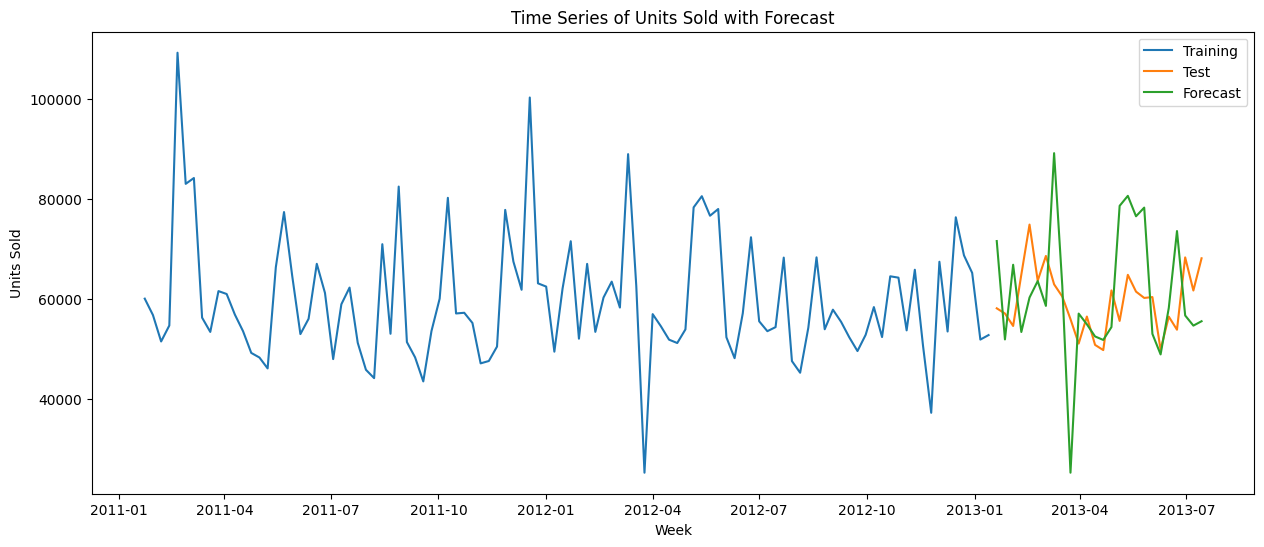

In [19]:
plt.figure(figsize=(15, 6))

plt.plot(train_data_resample, label='Training')
plt.plot(test_data_resample, label='Test')
plt.plot(predictions_resample, label='Forecast')

plt.title('Time Series of Units Sold with Forecast')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.legend()

plt.show()